In [1]:
import scanpy as sc
import cupy as cp
import time
import rapids_singlecell as rsc
import warnings
warnings.filterwarnings("ignore")

/home/dbj/anaconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=1,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
adata=sc.read_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig6Low—quality-CosMx-Human-Kidney-Cancer.h5ad')

In [4]:
rsc.get.anndata_to_GPU(adata)

In [5]:
%%time
rsc.pp.neighbors(adata,use_rep='SpaLP')
rsc.tl.leiden(adata, resolution=0.5,key_added='SpaLP',random_state=2024)

CPU times: user 31.3 s, sys: 4.57 s, total: 35.9 s
Wall time: 35.8 s


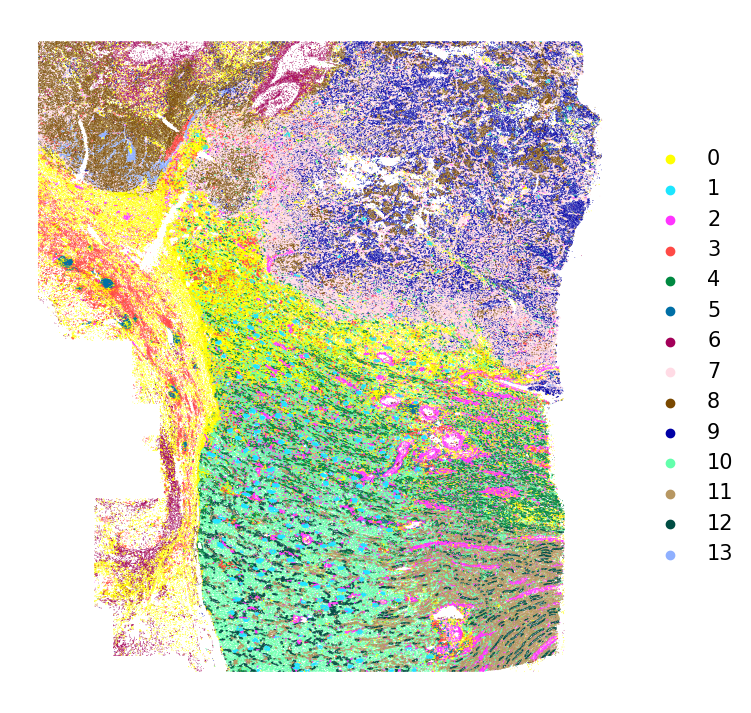

In [6]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,9)
plt.rcParams['font.size'] = 15
default_colors = sc.pl.palettes.default_102
sc.pl.embedding(adata, basis="spatial",s=1, color=['SpaLP'],title='',colorbar_loc=None,frameon=False,palette=default_colors)

In [7]:
adata=sc.read_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig6Xenium_Gastric_cancer.h5ad')
rsc.get.anndata_to_GPU(adata)

In [8]:
%%time
rsc.pp.neighbors(adata,use_rep='SpaLP')
rsc.tl.leiden(adata, resolution=0.5,key_added='SpaLP',random_state=2024)

CPU times: user 9.59 s, sys: 3.33 s, total: 12.9 s
Wall time: 12.9 s


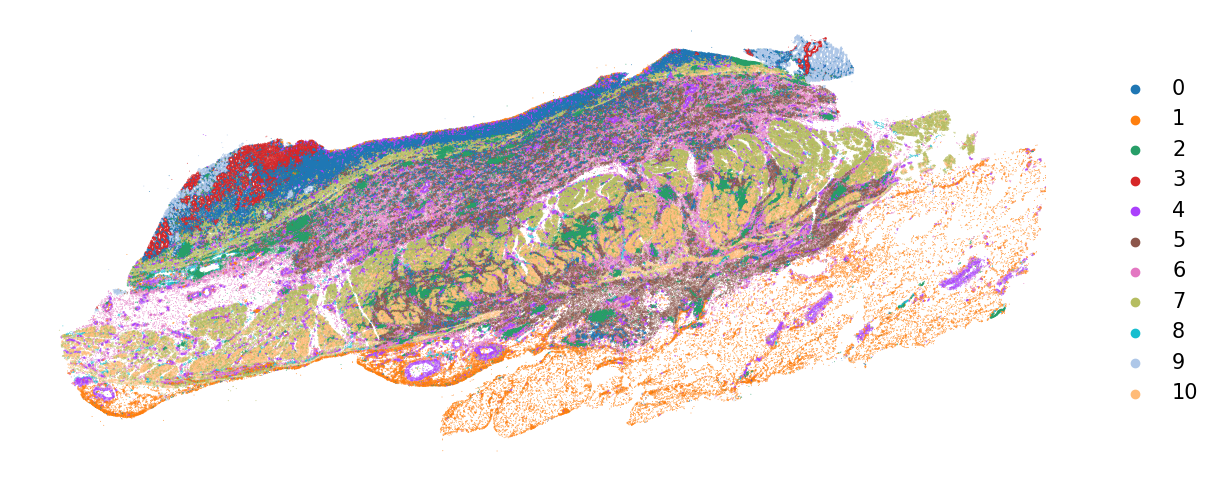

In [9]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,basis='spatial',color='SpaLP',size=1.5,frameon=False,title='',colorbar_loc=None)

... storing 'SpaLP_highlight' as categorical


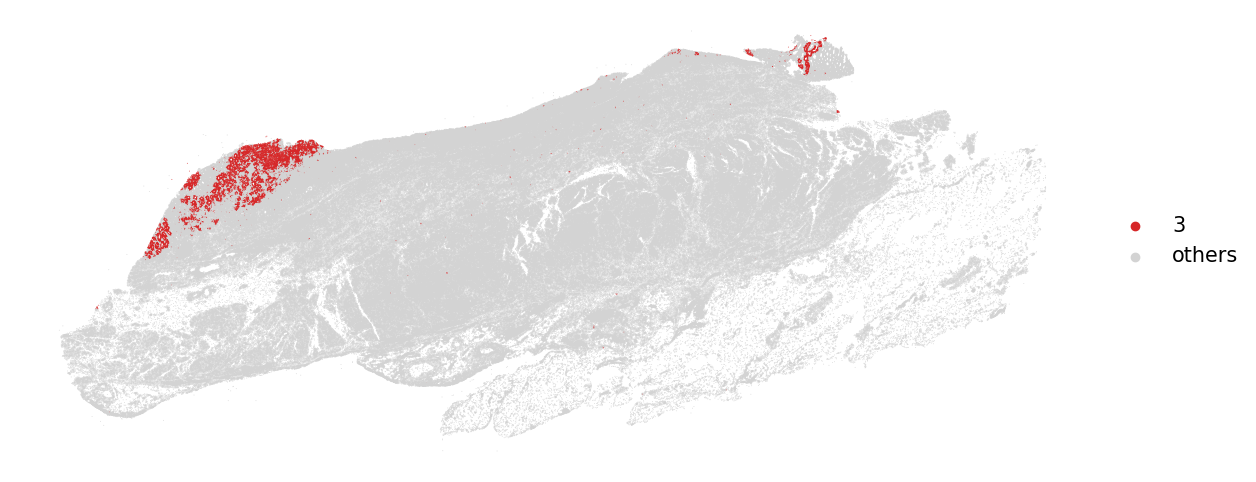

In [10]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[3] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '3', '3', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'3': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='')

... storing 'SpaLP_highlight' as categorical


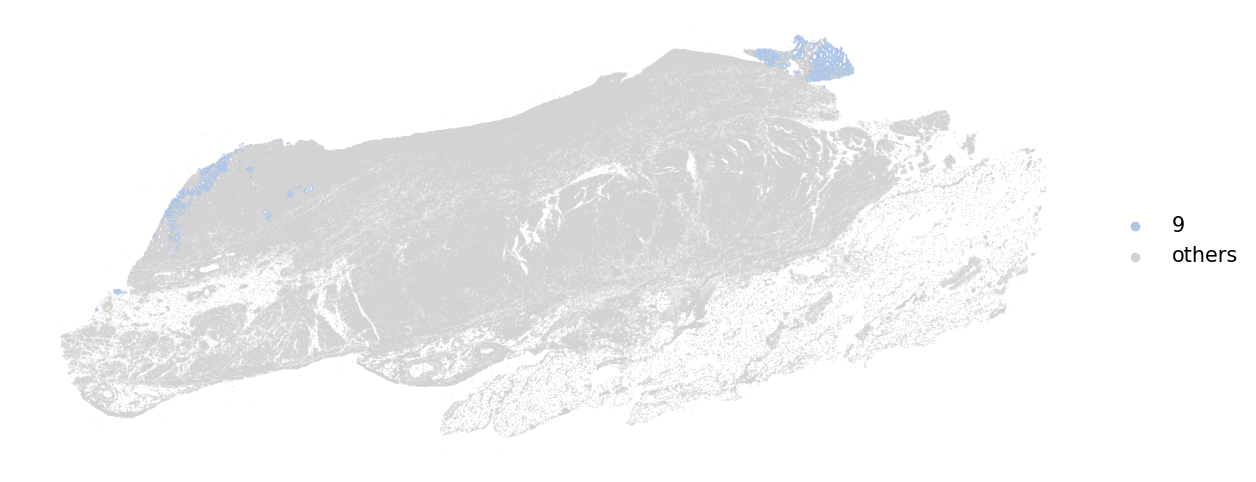

In [11]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[9] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '9', '9', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'9': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='')

In [12]:
adata=sc.read_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig6Xenium_multi-omics.h5ad')
rsc.get.anndata_to_GPU(adata)

In [13]:
%%time
rsc.pp.neighbors(adata,use_rep='SpaLP')
rsc.tl.leiden(adata, resolution=0.63,key_added='SpaLP')

CPU times: user 5.31 s, sys: 2.19 s, total: 7.5 s
Wall time: 7.5 s


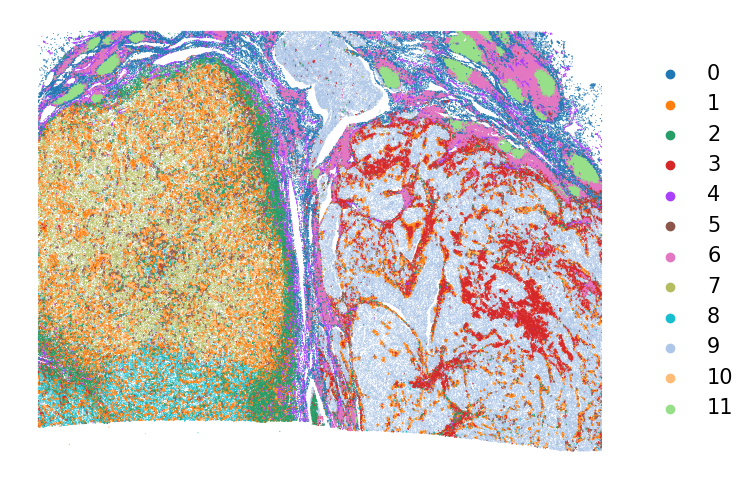

In [14]:
adata.obsm['spatial'][:,1] = -adata.obsm['spatial'][:,1]
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpaLP',ax=ax,title='',frameon=False,size=2)

In [15]:
adata.raw=adata
sc.tl.rank_genes_groups(adata, groupby="SpaLP", method="wilcoxon")
adata.uns["rank_features_groups"]=adata.uns["rank_genes_groups"]

In [16]:
import pandas as pd
markers = adata.uns['rank_genes_groups']    
groups  = markers['names'].dtype.names         
topn    = 5
cluster_markers = {
    g: [markers['names'][g][i] for i in range(topn)]
    for g in groups
}

In [17]:
feature_type = adata.var['feature_type']
stats = []  

for clust, genes in cluster_markers.items():
    rna_count = sum(feature_type.get(gene) == 'RNA' for gene in genes)
    protein_count = sum(feature_type.get(gene) == 'Protein' for gene in genes)

    stats.append({
        'cluster': clust,
        'RNA': rna_count,
        'Protein': protein_count
    })

df_counts = pd.DataFrame(stats).set_index('cluster')
print(df_counts)

         RNA  Protein
cluster              
0          4        1
1          3        2
2          0        5
3          2        3
4          3        2
5          2        3
6          1        4
7          4        1
8          3        2
9          5        0
10         1        4
11         2        3


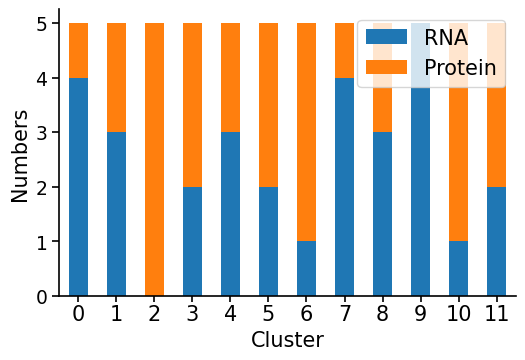

In [18]:
import matplotlib.pyplot as plt
import numpy as np
ax = df_counts.plot(kind='bar', stacked=True, figsize=(5.5,4))
ax.set_ylabel('Number of marker genes')
ax.set_xlabel('Cluster')
ax.set_title('Top 5 marker')
plt.tight_layout()
plt.title('', fontsize=18)       
plt.xlabel('Cluster', fontsize=15)      
plt.ylabel('Numbers', fontsize=15) 
plt.xticks(rotation=45)        
plt.tight_layout()

ax.grid(False)
ax.tick_params(
    axis='x',
    rotation=0,
    labelsize=15,
    length=4,      
    width=1.2,       
    pad=2,
    left=True
)

ax.tick_params(axis='y',
    length=5,       
    width=1.2,       
    labelsize=13.5,
    left=True
)
#ax.legend_.remove()

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig("/home/dbj/SpaLA/Xeniummultiomics/marker_counts15.png", dpi=500, bbox_inches='tight')
plt.show()

In [19]:
ranked_genes_data = adata.uns['rank_genes_groups']
top_5_genes_per_group = {}
all_top_5_genes = []

for group_name in ranked_genes_data['names'].dtype.names:
    genes_for_this_group = ranked_genes_data['names'][group_name][:5].tolist()
    top_5_genes_per_group[group_name] = genes_for_this_group
    all_top_5_genes.extend(genes_for_this_group)

print("Top5marker：")
for group, genes in top_5_genes_per_group.items():
    print(f"  Cluster {group}: {genes}")

unique_top_5_genes = list(set(all_top_5_genes))

Top5marker：
  Cluster 0: ['PTEN', 'TNC', 'CRISPLD2', 'LYVE1', 'ADAMTS1']
  Cluster 1: ['alphaSMA', 'Vimentin', 'PDGFRB', 'VIM', 'ACTA2']
  Cluster 2: ['CD8A', 'CD3E', 'CD163', 'CD45RO', 'PD-1']
  Cluster 3: ['CD3E', 'SLAMF7', 'MZB1', 'CD31', 'CD16']
  Cluster 4: ['PTEN', 'VWF', 'CD31', 'PECAM1', 'CD93']
  Cluster 5: ['HLA-DR', 'CD68', 'FCGR3A', 'CD16', 'FCGR3B']
  Cluster 6: ['CD3E', 'CD45RA', 'CD45', 'CD4', 'PTPRC']
  Cluster 7: ['VIM', 'CXCL6', 'SEMA3C', 'MET', 'Vimentin']
  Cluster 8: ['PTGDS', 'RBP5', 'MET', 'Vimentin', 'PCNA']
  Cluster 9: ['CXCL6', 'MET', 'KRT8', 'KRT18', 'HAVCR2']
  Cluster 10: ['alphaSMA', 'ACTA2', 'Vimentin', 'CD31', 'Beta-catenin']
  Cluster 11: ['CD20', 'CD45RA', 'MS4A1', 'CD45', 'CXCR4']
